# Build dataset, compiling data and metadata from various sources

- This compiles original input video (mp4), inferenced outputs keypoints and edges in pkl files, constructs and filters paths for quality, and structures data into Video instances
- Note that inferenced keypoints (num_frames x 17 x 3) and edges (num_frames x 18 x 2 x 2)
- out_keypoints is frame, keypoint, (y, x, confidence)
- out_edges is an (frame, edge-pair,  array of x-y arrays) where np.array([[x_start, y_start], [x_end, y_end]])

# load preliminaries, checkpoints

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import cv2
import yaml
import json
import os
import sys
import glob
import pickle as pkl
import importlib
import fnmatch
from pathlib import Path
import tensorflow as tf

In [2]:
%cd ..

/Users/donwei7/Documents/code/human_motion_analysis


In [3]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/Users/donwei7/Documents/code/human_motion_analysis


In [4]:
# custom modules
from src.io import iomod
from src.io.utils import Config
from src.inference import inference
from src.visualization import draw
from src.analysis import analysisphysics
from src.tests import testdraw, structshape
from src.train import datatransform

# Import plotting libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection # likely limited to draw module
import matplotlib.patches as patches
import seaborn as sns

# set sns
sns.set()

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display, Image

In [5]:
config = Config()

## deprecated: load inferenced data (if already compiled)

In [6]:
# # a df of video paths and inferenced keypoints (num_frames x 17 x 3) and edges (num_frames x 18 x 2 x 2)
# # out_edges is an (frame, edge-pair,  array of x-y arrays) where np.array([[x_start, y_start], [x_end, y_end]])
# with open(Path(ROOT_DIR).joinpath("data", "compiled", "df_kpts"), 'rb') as f:
#     df_kpts = pkl.load(f)

# # cumulative edge velocities and lengths for histograms
# with open(Path(ROOT_DIR).joinpath("data", "compiled", "edge_vel_all"), 'rb') as f:
#     edge_vel_all = pkl.load(f)
# with open(Path(ROOT_DIR).joinpath("data", "compiled", "edge_length_all"), 'rb') as f:
#     edge_length_all = pkl.load(f)

# filter for quality, compile data and metadata, organize into list of Video instances

In [7]:
from src.io.dstypes import Video, Metadata
from functools import reduce
from typing import List

In [8]:
def filter_paths(paths, **kwargs):
	return filter(lambda path: not any(fnmatch.fnmatch(path, r) for r in kwargs["remove_pattern"]), paths)

def filter_str(paths, **kwargs):
	return filter(lambda path: kwargs["query"] in str(path), paths)

def filter_exists_pkl(paths, **kwargs):
	return filter(lambda path: (Path(f"{path}_out_keypoints.pkl").exists() and Path(f"{path}_out_edges.pkl").exists()), paths)

In [9]:
def compile_Videos(filtered_paths: List[Path]):
	videos = []
	for pi, path in enumerate(filtered_paths):
		with open(f"{path}_out_keypoints.pkl", 'rb') as f:
			keypoints = pkl.load(f)
		with open(f"{path}_out_edges.pkl", 'rb') as f:
			edges = pkl.load(f)
		video = Video(
			path = path,
			kpts_pred = keypoints.reshape(-1, 17, 3),
			edges_pred = edges,
			stem_name = path.stem,
			exercise_name = query,
			metadata = Metadata(
				dataset_name = path.parts[-3],
				dataset_version = {"MAJOR": 1, "MINOR": 0, "PATCH": 0}
			)
		)
		videos.append(video)
	return videos

In [10]:
# filter for quality for armraise
all_paths = list(Path(ROOT_DIR).joinpath("data", "infinity").rglob("*.mp4"))
filters = [filter_paths, filter_str, filter_exists_pkl]
remove_pattern = [
	"*armraise*video.rgb.mp4", "*armraise*000004.mp4", "*armraise*000005.mp4", "*armraise*000006.mp4", "*armraise*000009.mp4", "*armraise*000013.mp4", "*armraise*000018.mp4", \
	"*armraise*000019.mp4", "*armraise*000033.mp4", "*armraise*000039.mp4", "*armraise*000042.mp4", "*armraise*000044.mp4", "*armraise*000066.mp4", "*armraise*000076.mp4", "*armraise*000094.mp4", "*armraise*000097.mp4", "*armraise*000099.mp4",
	"*armraise*000025.mp4", "*armraise*000044.mp4", "*armraise*000035.mp4", "*armraise*000026.mp4", "*armraise*000020.mp4"
]
query = "armraise"
kwargs = {"remove_pattern": remove_pattern, "query": query}

filtered_paths_armraise = list(reduce(lambda acc, f: f(acc, **kwargs), filters, all_paths))
videos_armraise = compile_Videos(filtered_paths_armraise)


In [11]:
# same thing for curl
all_paths = list(Path(ROOT_DIR).joinpath("data", "infinity").rglob("*.mp4"))
filters = [filter_paths, filter_str, filter_exists_pkl]
remove_pattern = [
	"*curl*000001.mp4", "*curl*000022.mp4", "*curl*000025.mp4", "*curl*000034.mp4", "*curl*000035.mp4", "*curl*000043.mp4", "*curl*000049.mp4", \
	"*curl*000053.mp4", "*curl*000056.mp4", "*curl*000057.mp4", "*curl*000060.mp4", "*curl*000061.mp4", "*curl*000068.mp4", "*curl*000080.mp4", \
	"*curl*000080.mp4", "*curl*000082.mp4", "*curl*000090.mp4"
]
query = "curl"
kwargs = {"remove_pattern": remove_pattern, "query": query}

filtered_paths_curl = list(reduce(lambda acc, f: f(acc, **kwargs), filters, all_paths))
videos_curl = compile_Videos(filtered_paths_curl)

In [12]:
from src.io.utils import convert_inst_to_df

df_armraise = convert_inst_to_df(videos_armraise)
df_curl = convert_inst_to_df(videos_curl)

# load json and extract truth data

Note there appears to be bug with prior synthetic data making certain armature_keypoints e.g. right_knee constant across frames - will have to ignore or generate new frames later

In [13]:
# load armature_keypoints into dataframe
kpts_all = []
for path in filtered_paths_armraise:
	path_json = path.parent / f"{path.stem}.json"
	with open(path_json, "r") as f:
		data_true = json.load(f)
	for fri in range(len(data_true["annotations"])):
		image_width = data_true["images"][0].get("width")
		image_height = data_true["images"][0].get("height")
		armature_kpts = data_true["annotations"][fri].get("armature_keypoints")
		if armature_kpts:
			frame_kpts = [
				(path.stem, fri, image_width, image_height, kpt,
					armature_kpts[kpt]["y"], armature_kpts[kpt]["x"]
				)
				for kpt in armature_kpts.keys()
			]
			kpts_all.extend(frame_kpts)

df_kpts_true = pd.DataFrame(kpts_all, columns=[
	"stem", "frame", "image_width", "image_height",
	"kpt", "y", "x",
])

# extract df_kpts_true into kpts_true - pivot approach
for video in videos_armraise:
	video.image_width = df_kpts_true[df_kpts_true.stem == video.stem_name].iloc[0].image_width
	video.image_height = df_kpts_true[df_kpts_true.stem == video.stem_name].iloc[0].image_height
	pivot_y = df_kpts_true[df_kpts_true.stem == video.stem_name]\
		.pivot_table(index='frame', columns='kpt', values=['y'])\
		.droplevel(0, axis=1)\
		.reindex(columns=list(config.kpts.keys()))
	pivot_x = df_kpts_true[df_kpts_true.stem == video.stem_name]\
		.pivot_table(index='frame', columns='kpt', values=['x'])\
		.droplevel(0, axis=1)\
		.reindex(columns=list(config.kpts.keys()))
	yx_cat = np.concatenate((np.expand_dims(pivot_y.to_numpy(), axis=2), np.expand_dims(pivot_x.to_numpy(), axis=2)), axis=2)
	yx_cat = yx_cat / video.image_width
	video.kpts_true = yx_cat


In [14]:
# same but for curl
kpts_all = []
for path in filtered_paths_curl:
	path_json = path.parent / f"{path.stem}.json"
	with open(path_json, "r") as f:
		data_true = json.load(f)
	for fri in range(len(data_true["annotations"])):
		image_width = data_true["images"][0].get("width")
		image_height = data_true["images"][0].get("height")
		armature_kpts = data_true["annotations"][fri].get("armature_keypoints")
		if armature_kpts:
			frame_kpts = [
				(path.stem, fri, image_width, image_height, kpt,
					armature_kpts[kpt]["y"], armature_kpts[kpt]["x"]
				)
				for kpt in armature_kpts.keys()
			]
			kpts_all.extend(frame_kpts)

df_kpts_true = pd.DataFrame(kpts_all, columns=[
	"stem", "frame", "image_width", "image_height",
	"kpt", "y", "x",
])

# extract df_kpts_true into kpts_true - pivot approach
for video in videos_curl:
	video.image_width = df_kpts_true[df_kpts_true.stem == video.stem_name].iloc[0].image_width
	video.image_height = df_kpts_true[df_kpts_true.stem == video.stem_name].iloc[0].image_height
	pivot_y = df_kpts_true[df_kpts_true.stem == video.stem_name]\
		.pivot_table(index='frame', columns='kpt', values=['y'])\
		.droplevel(0, axis=1)\
		.reindex(columns=list(config.kpts.keys()))
	pivot_x = df_kpts_true[df_kpts_true.stem == video.stem_name]\
		.pivot_table(index='frame', columns='kpt', values=['x'])\
		.droplevel(0, axis=1)\
		.reindex(columns=list(config.kpts.keys()))
	yx_cat = np.concatenate((np.expand_dims(pivot_y.to_numpy(), axis=2), np.expand_dims(pivot_x.to_numpy(), axis=2)), axis=2)
	yx_cat = yx_cat / video.image_width
	video.kpts_true = yx_cat


## plot true and predicted data
- limit plotting to available keypoints in json
- appears to largely recapitulate, supporting feasibility, although some high frequency oscillations - explore further

In [29]:
videos_armraise[30].stem_name, videos_armraise[30].exercise_name

('000060', 'armraise')

In [30]:
videos_curl[30].stem_name, videos_curl[30].exercise_name

('000048', 'curl')

In [33]:
filtered_paths_armraise[2], filtered_paths_curl[2]

(PosixPath('/Users/donwei7/Documents/code/human_motion_analysis/data/infinity/InfinityAI_InfiniteRep_armraise_v1.0/data/000011.mp4'),
 PosixPath('/Users/donwei7/Documents/code/human_motion_analysis/data/infinity/InfinityAI_InfiniteRep_curl_v1.0/data/000004.mp4'))

Text(0.5, 0.98, 'exercise: armraise, video: 000010')

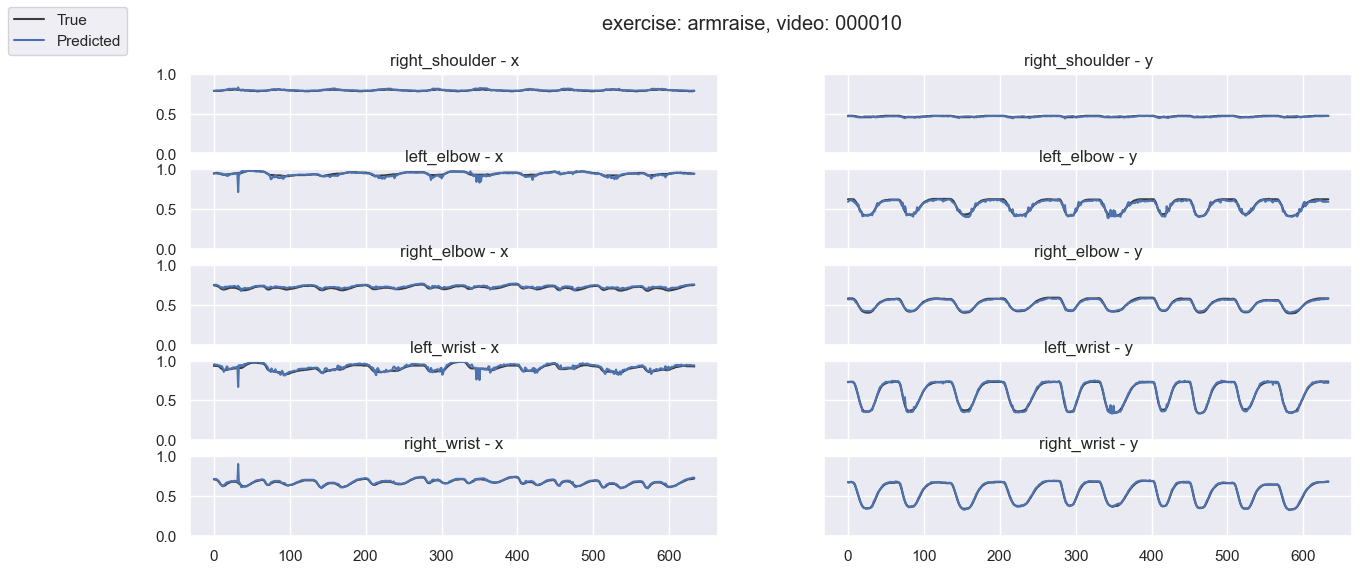

In [18]:
# turn on interactive
# %matplotlib widget
%matplotlib inline

video_idx = 1
video = videos_armraise[video_idx]
kpts_plt = list(config.kpts)[6:11]

kpts_true = video.kpts_true
kpts_pred = video.kpts_pred

fig, axs = plt.subplots(len(kpts_plt), 2, figsize=(15, 6), sharey=True, sharex=True)

for idx, kpt in enumerate(kpts_plt, start=6):
    axs[idx-6, 0].plot(kpts_true[:, idx, 1], label="True", color="black", alpha=0.75)
    axs[idx-6, 0].plot(kpts_pred[:, idx, 1], label="Predicted")
    axs[idx-6, 0].set_title(f"{kpt} - x")
    axs[idx-6, 1].plot(kpts_true[:, idx, 0], label="True", color="black", alpha=0.75)
    axs[idx-6, 1].plot(kpts_pred[:, idx, 0], label="Predicted")
    axs[idx-6, 1].set_title(f"{kpt} - y")

lines, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper left")

axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)

plt.subplots_adjust(hspace=0.2)
plt.suptitle(f"exercise: {video.exercise_name}, video: {video.stem_name}")


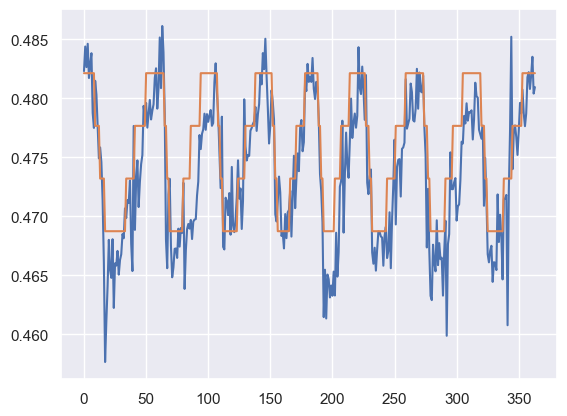

In [35]:
plt.plot(kpts_pred[:, 6, 0])
plt.plot(kpts_true[:, 6, 0])

Text(0.5, 0.98, 'exercise: curl, video: 000010')

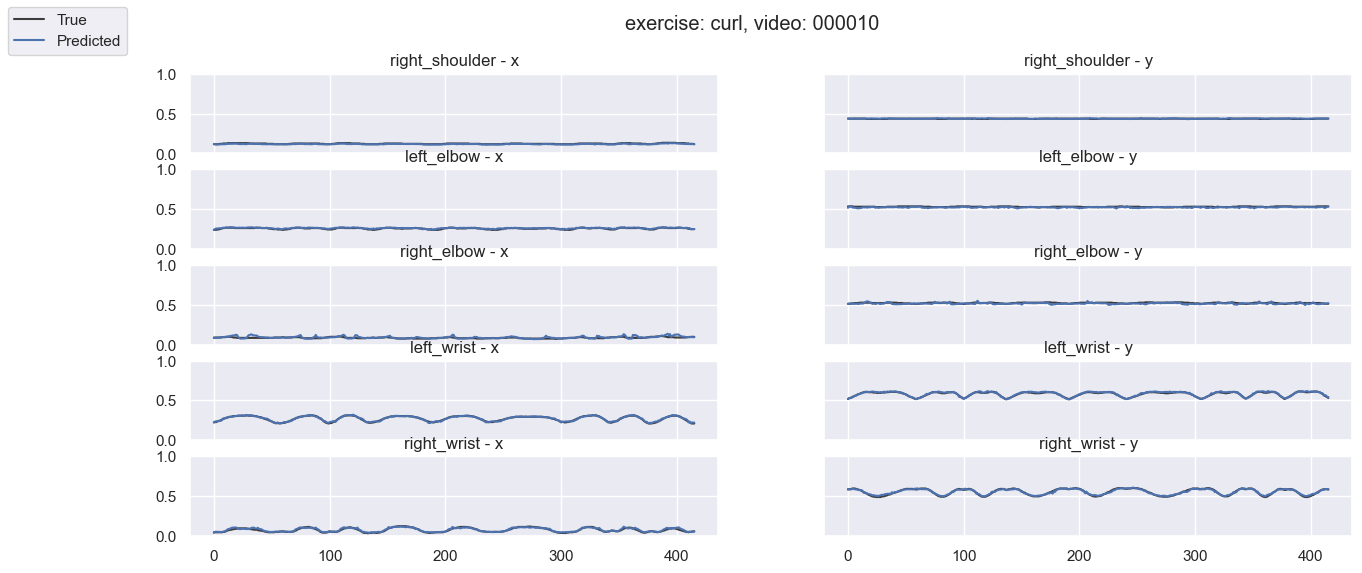

In [19]:
# same but for curl
# %matplotlib widget

video_idx = 1
video = videos_curl[video_idx]
kpts_plt = list(config.kpts)[6:11]

kpts_true = video.kpts_true
kpts_pred = video.kpts_pred

fig, axs = plt.subplots(len(kpts_plt), 2, figsize=(15, 6), sharey=True, sharex=True)

for idx, kpt in enumerate(kpts_plt, start=6):
    axs[idx-6, 0].plot(kpts_true[:, idx, 1], label="True", color="black", alpha=0.75)
    axs[idx-6, 0].plot(kpts_pred[:, idx, 1], label="Predicted")
    axs[idx-6, 0].set_title(f"{kpt} - x")
    axs[idx-6, 1].plot(kpts_true[:, idx, 0], label="True", color="black", alpha=0.75)
    axs[idx-6, 1].plot(kpts_pred[:, idx, 0], label="Predicted")
    axs[idx-6, 1].set_title(f"{kpt} - y")

lines, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc="upper left")

axs[0, 0].set_ylim(0, 1)
axs[0, 1].set_ylim(0, 1)

plt.subplots_adjust(hspace=0.2)
plt.suptitle(f"exercise: {video.exercise_name}, video: {video.stem_name}")

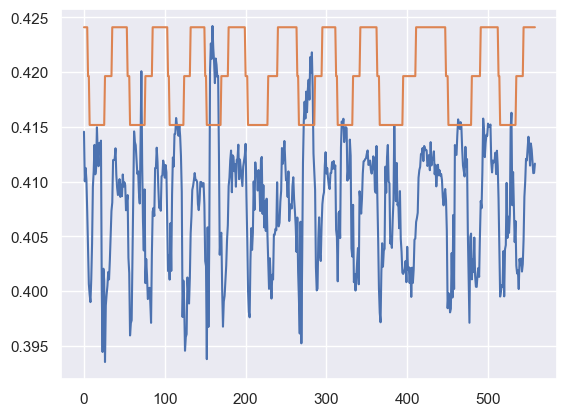

In [ ]:
# turn off widget
%matplotlib inline

plt.plot(kpts_pred[:, 6, 0])
plt.plot(kpts_true_interp[:, 6, 0])

# exploring json truth data structure

In [58]:
print(structshape.getshape(data_true["info"]))
print(data_true["info"].keys())

dict of 12 str->(str, int, list of 10 float, float)
dict_keys(['url', 'date_created', 'camera_pitch', 'camera_height', 'avatar_presenting_gender', 'avatar_attire_top', 'avatar_attire_bottom', 'avatar_betas', 'avatar_waist_circumference', 'video_number', 'video_id', 'scene_id'])


In [59]:
print(structshape.getshape(data_true["categories"]))
print(data_true["categories"][0].keys())

list of (dict of 5 str->(list of 19 list of 2 int, int, str, list of 17 str, list of 3 float), dict of 3 str->(str, int, list of 3 float))
dict_keys(['id', 'name', 'color', 'keypoints', 'skeleton'])


In [69]:
print(structshape.getshape(data_true["images"]))
print(data_true["images"][0].get("id"))

list of 578 dict of 5 str->(int, float)
0


In [71]:
data_true["info"]

{'url': 'https://toinfinity.ai/',
 'date_created': '20220201_000000',
 'camera_pitch': 89.5514708118726,
 'camera_height': 1.403493046760559,
 'avatar_presenting_gender': 'male',
 'avatar_attire_top': 'tank',
 'avatar_attire_bottom': 'jeans',
 'avatar_betas': [-0.32741034030914307,
  -0.27238011360168457,
  -0.2695607841014862,
  -0.5417943596839905,
  0.05921624228358269,
  0.8379880785942078,
  0.48615506291389465,
  0.7798305749893188,
  0.3127519488334656,
  -0.19323185086250305],
 'avatar_waist_circumference': 0.9262114776552794,
 'video_number': 0,
 'video_id': '20220201-140909',
 'scene_id': '3122859'}

In [89]:
print(structshape.getshape(data_true["annotations"][2]))
print(data_true["annotations"][2])

dict of 11 str->(list of 4 float, list of 3 float, list of (list of 10 float, list of 12 float), list of 8 dict of 2 str->int, float, int)
{'category_id': 1, 'image_id': 0, 'id': 2, 'iscrowd': 0, 'color': [0.5607843137254902, 0.996078431372549, 0.03529411764705882], 'area': 175.46040000000025, 'segmentation': [[55.0, 152.99, 53.01, 151.0, 56.0, 147.01, 57.99, 150.0, 55.0, 152.99], [65.0, 157.99, 63.010000000000005, 156.0, 67.0, 150.01, 68.99, 152.0, 68.99, 155.0, 65.0, 157.99]], 'bbox': [53.01, 147.01, 15.979999999999997, 10.980000000000018], 'cuboid_coordinates': [{'x': 70, 'y': 143}, {'x': 71, 'y': 146}, {'x': 52, 'y': 147}, {'x': 52, 'y': 144}, {'x': 70, 'y': 155}, {'x': 71, 'y': 158}, {'x': 53, 'y': 159}, {'x': 52, 'y': 157}], 'percent_in_fov': 100.0, 'percent_occlusion': 18.644067796610166}


In [117]:
data_true["annotations"][0].keys()

dict_keys(['category_id', 'image_id', 'id', 'iscrowd', 'color', 'area', 'segmentation', 'bbox', 'cuboid_coordinates', 'quaternions', 'percent_in_fov', 'keypoints', 'num_keypoints', 'armature_keypoints', 'percent_occlusion'])

In [114]:
def print_dict_structure(d, indent=0):
    for key, value in d.items():
        print(" " * indent + str(key))
        if isinstance(value, dict):
            print_dict_structure(value, indent+4)
        else:
            print(" " * (indent+4) + str(value))

print_dict_structure(data_true["annotations"][0])

category_id
    0
image_id
    0
id
    0
iscrowd
    0
color
    [0.6, 0.0, 0.4]
area
    6840.5004
segmentation
    [[82.0, 202.99, 77.01, 200.0, 78.01, 187.0, 76.01, 182.0, 76.01, 162.0, 74.01, 155.0, 75.01, 128.0, 73.0, 122.99, 66.99, 130.0, 63.989999999999995, 141.0, 64.99, 150.0, 62.99, 154.0, 61.0, 155.99, 56.01, 151.0, 59.01, 144.0, 60.01, 131.0, 65.01, 117.0, 75.0, 106.01, 82.01, 102.0, 79.01, 96.0, 80.01, 92.0, 84.0, 87.01, 88.0, 87.01, 91.99, 90.0, 92.99, 93.0, 90.99, 103.0, 100.0, 108.01, 106.99, 118.0, 111.99, 134.0, 112.99, 145.0, 114.99, 148.0, 111.0, 152.99, 108.01, 151.0, 108.01, 141.0, 104.01, 129.0, 99.0, 119.99, 96.99, 123.0, 96.99, 136.0, 98.99, 141.0, 98.99, 157.0, 96.99, 164.0, 97.99, 176.0, 94.99, 186.0, 94.99, 192.0, 99.99, 198.0, 95.0, 200.99, 90.01, 194.0, 89.01, 169.0, 87.0, 159.99, 83.99, 171.0, 82.99, 184.0, 84.99, 200.0, 82.0, 202.99]]
bbox
    [56.01, 87.01, 58.98, 115.98]
cuboid_coordinates
    [{'x': 110, 'y': 87}, {'x': 115, 'y': 88}, {'x': 56, 'y': 8